<h2 style="text-align: center;">Generalized method of moments</h2>


In [118]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
from scipy.special import comb  # For binomial coefficients


In [119]:
class Vasicek:
    def __init__(self, kappa, theta, sigma):
        """
        Initialize the parameters for the Vasicek model.
        
        :param kappa: Speed of mean reversion
        :param theta: Long-term mean level
        :param sigma: Volatility of the process
        """
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def generate(self, X0, T, N, n):
        """
        Generate N trajectories of the Vasicek process on the interval [0, T] with a time step of T/n.
        
        :param X0: Initial value of the process
        :param T: The total time period
        :param N: Number of trajectories to generate
        :param n: Number of discretization steps (so time step is T/n)
        
        :return: Array of N trajectories discretized over the interval [0, T]
        """
        dt = T / n  # Adjusted time step for the interval [0, T]
        trajectories = np.zeros((N, n))  # Matrix to store the trajectories
        trajectories[:, 0] = X0  # Initialize all trajectories at X0

        for i in range(1, n):
            # Generate standard normal noise
            Z = np.random.randn(N)  # Standard normal random variables for each trajectory
            # Update the process value according to the Vasicek model
            trajectories[:, i] = (
                trajectories[:, i - 1] * np.exp(-self.kappa * dt)
                + self.theta * (1 - np.exp(-self.kappa * dt))
                +  np.sqrt((self.sigma**2) *(1 - np.exp(-2 * self.kappa * dt)) / (2 * self.kappa)) * Z
            )

        return trajectories


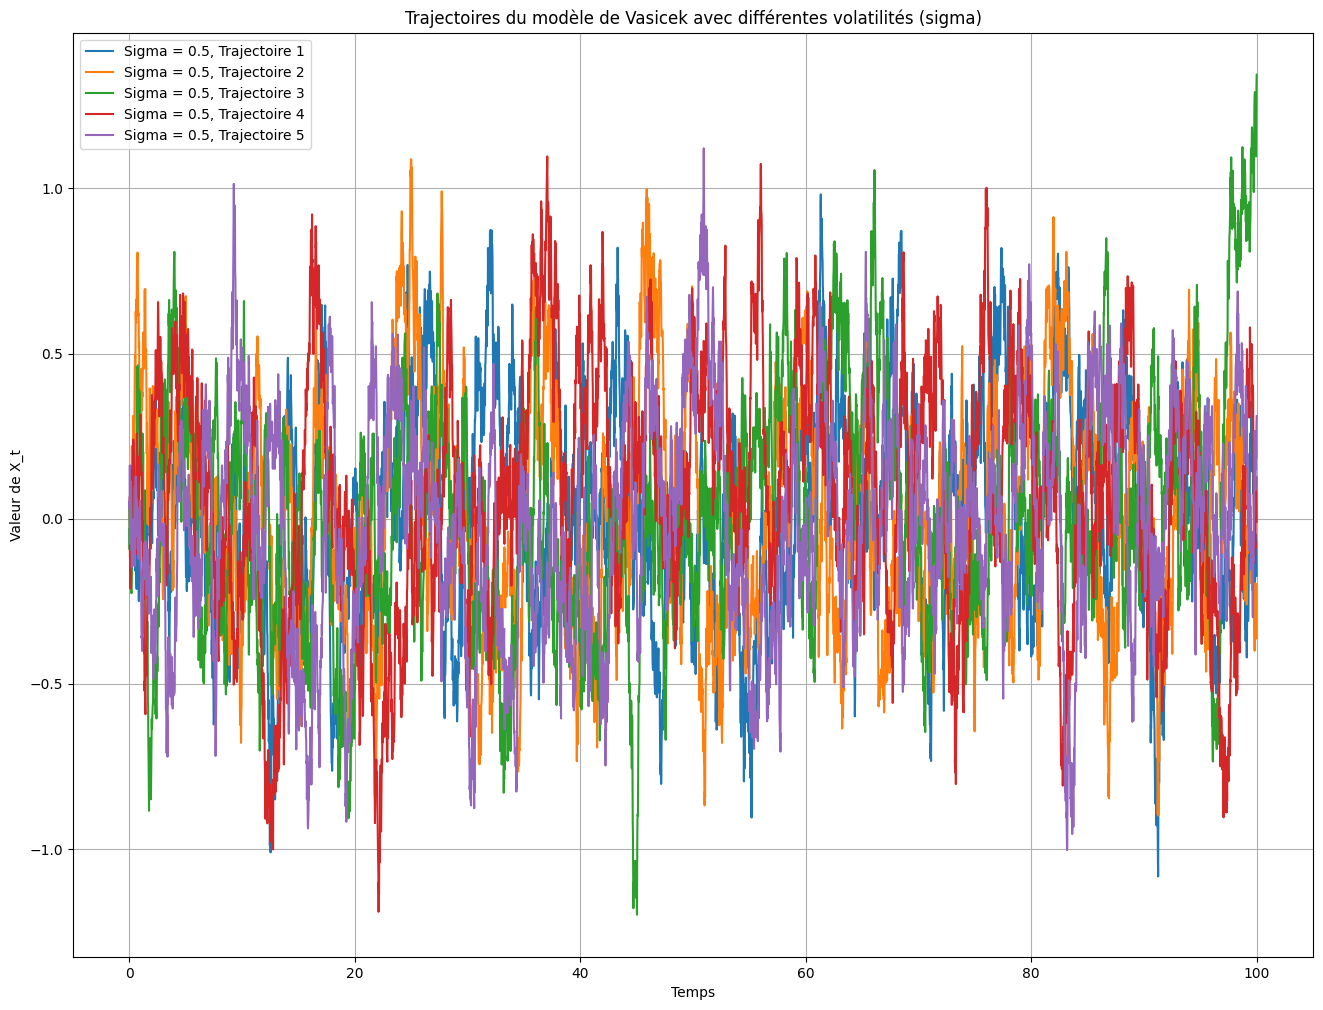

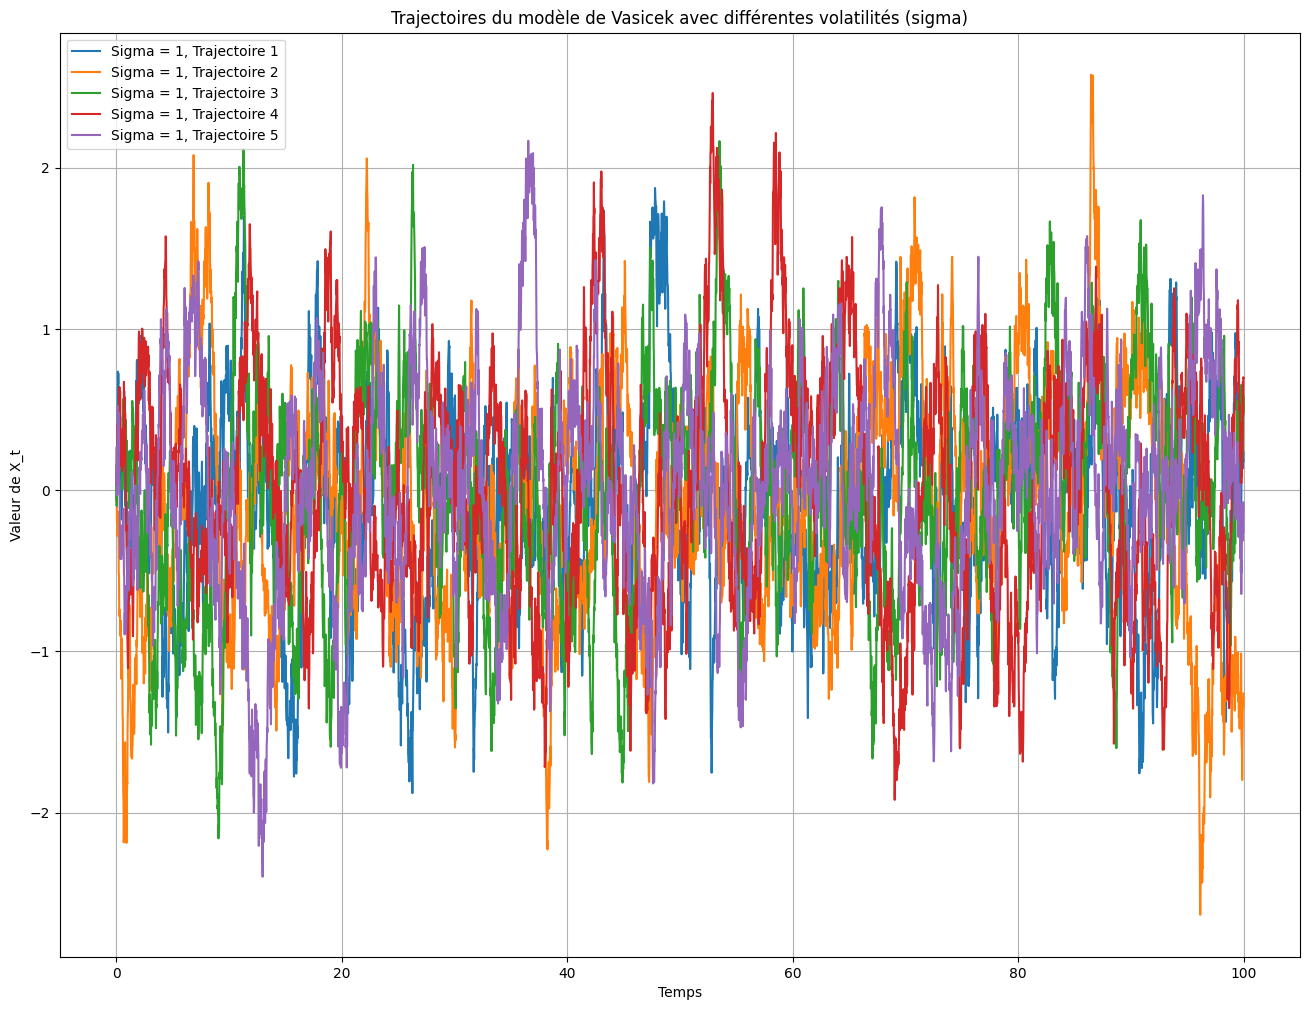

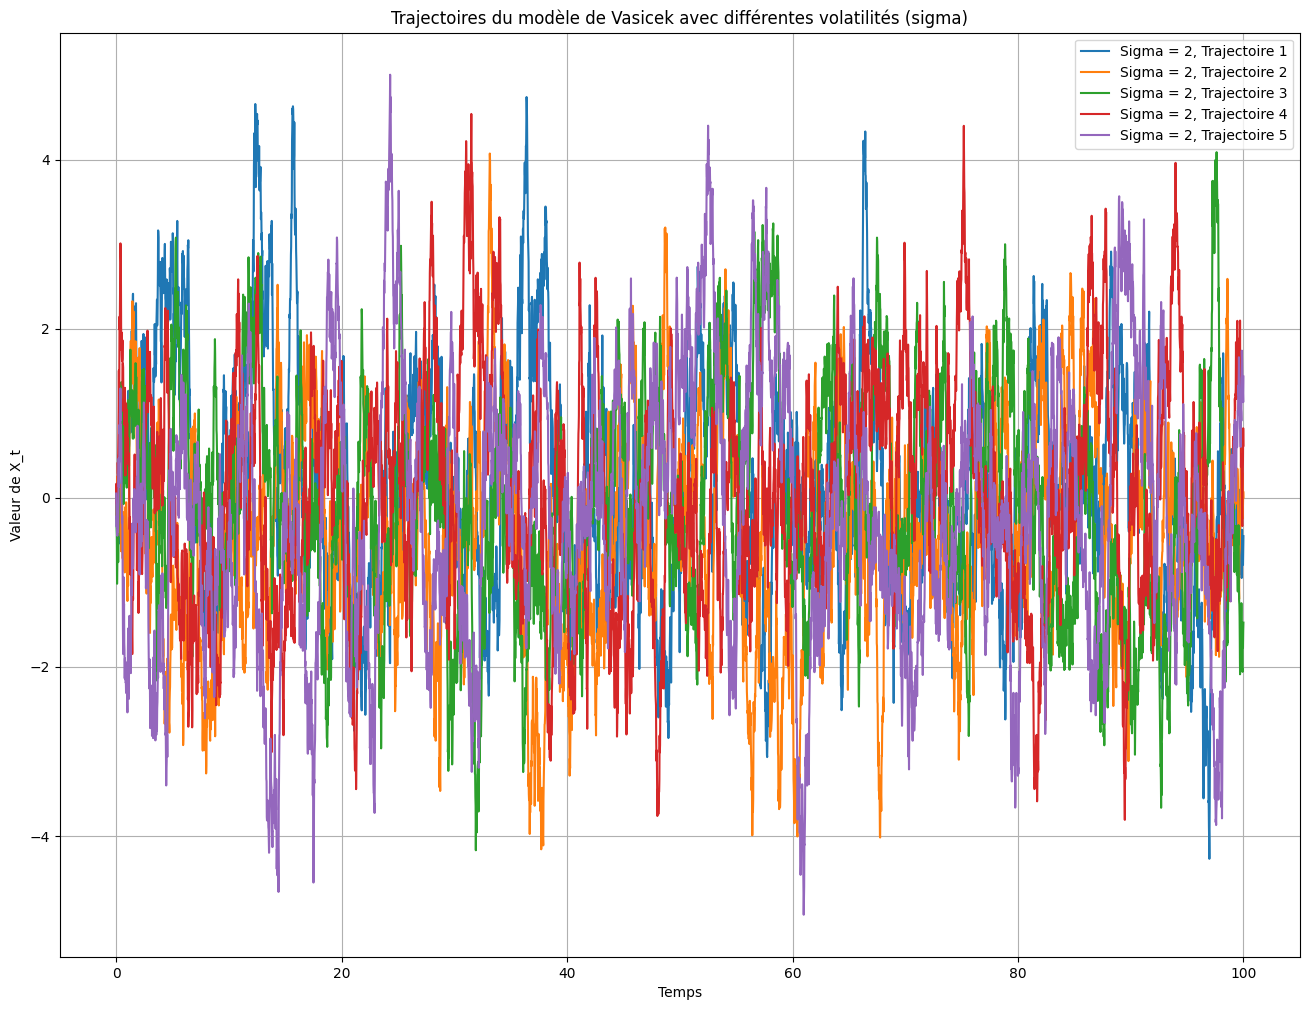

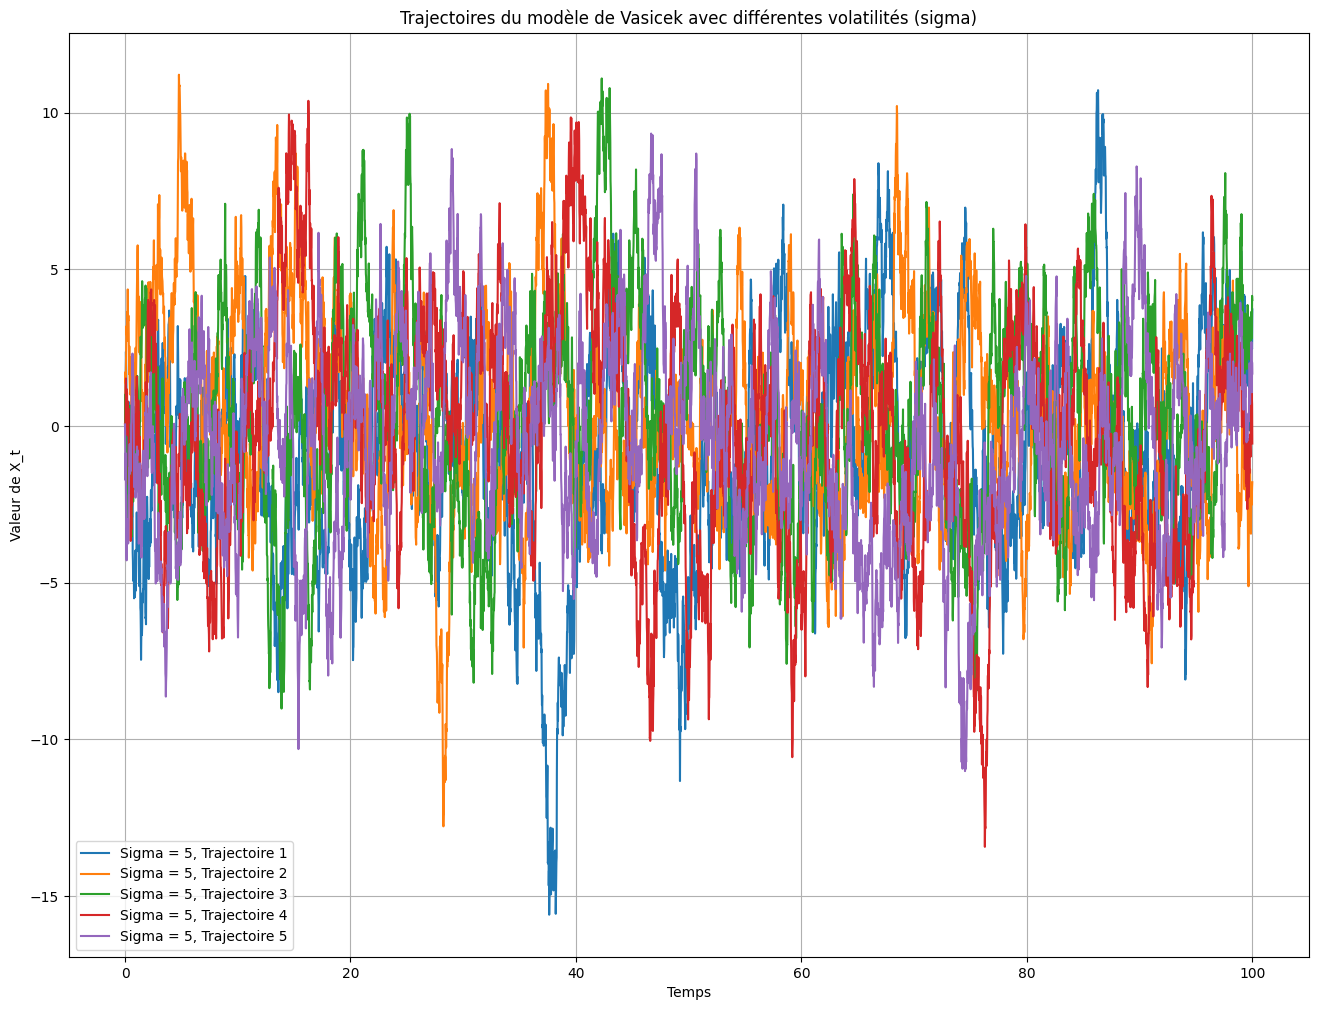

In [120]:
# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 5  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation
T = 100  # durée totale

# Liste des valeurs de sigma
sigma_values = [0.5, 1, 2, 5]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"Sigma = {sigma}, Trajectoire {i+1}")
    plt.title("Trajectoires du modèle de Vasicek avec différentes volatilités (sigma)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()


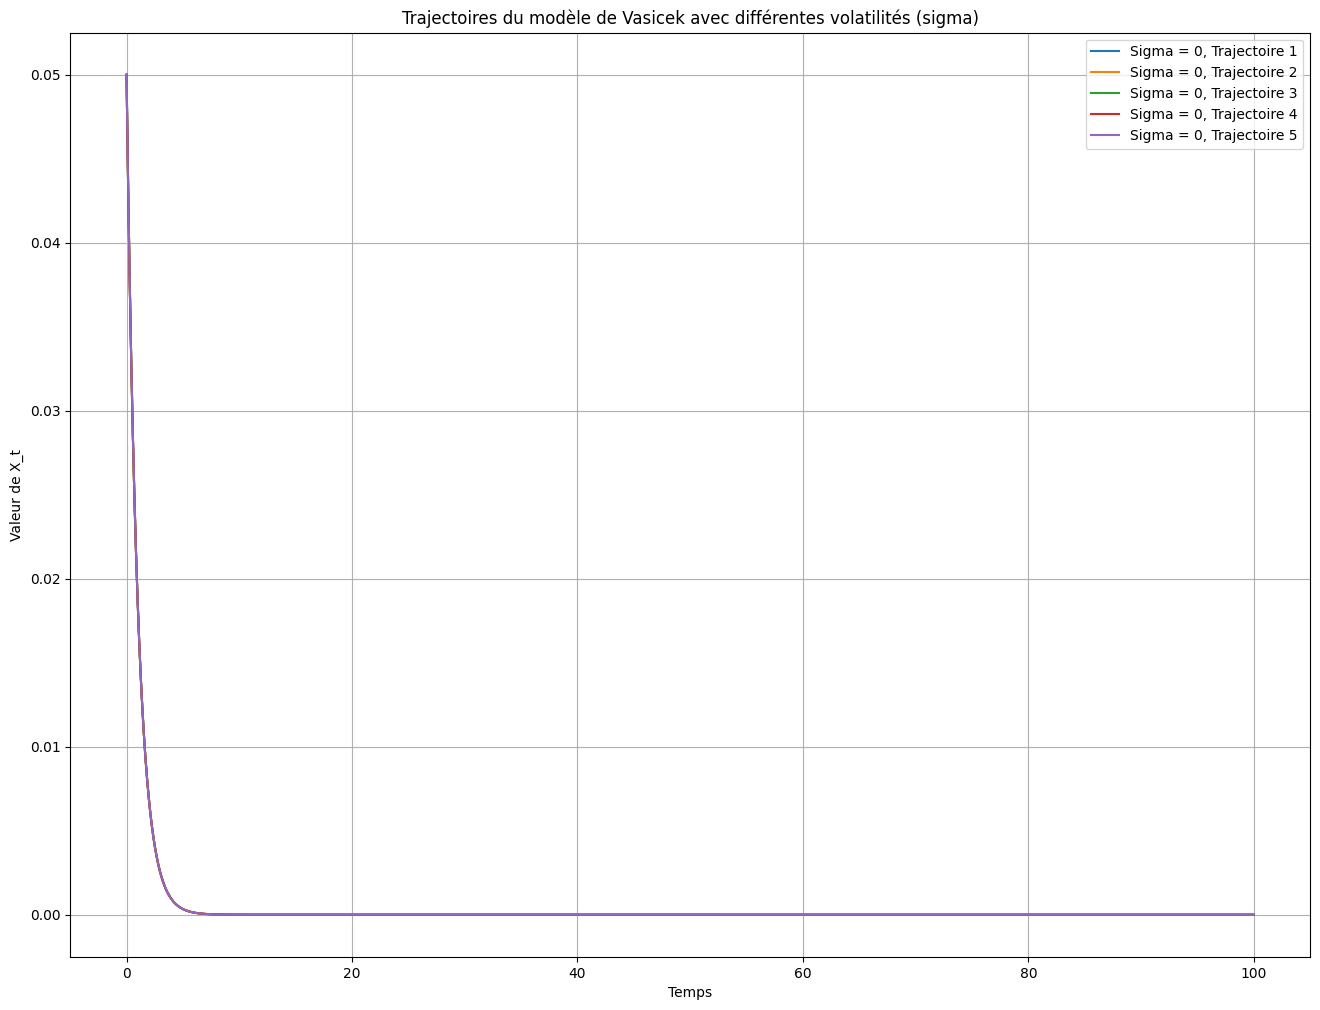

In [121]:
# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 5  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation
T = 100  # durée totale

# Liste des valeurs de sigma
sigma_values = [0]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"Sigma = {sigma}, Trajectoire {i+1}")
    
    plt.title("Trajectoires du modèle de Vasicek avec différentes volatilités (sigma)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()

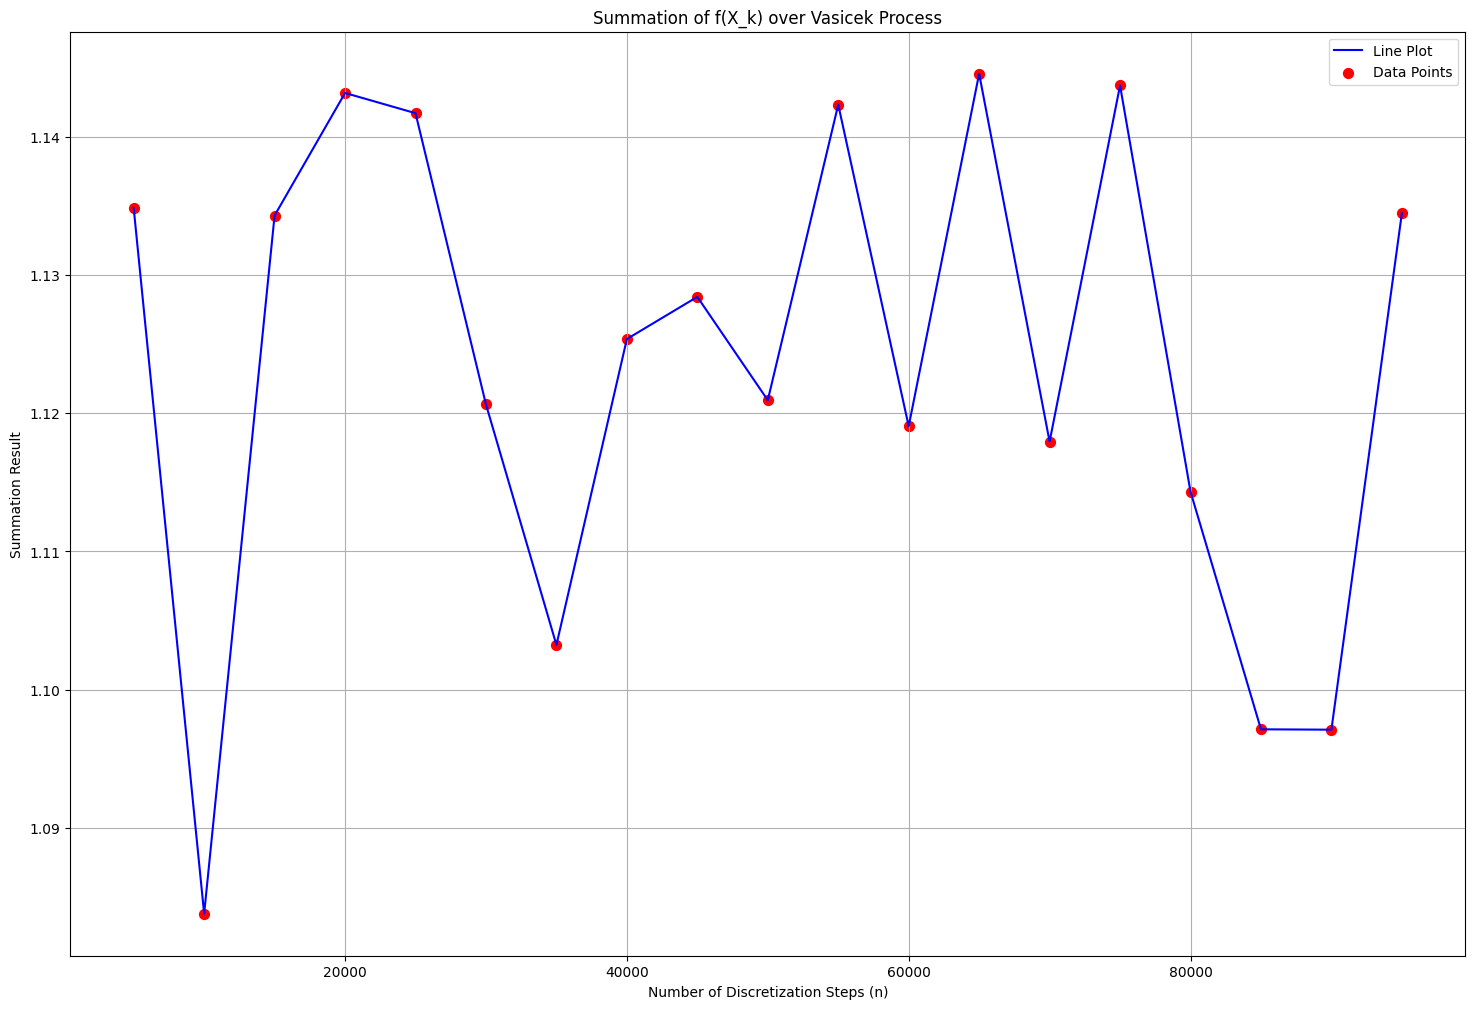

In [122]:
def calculate_sum(n, f, kappa=1, theta=1, sigma=0.5, X0=0.05,T=5000):
    """
    Calculate the summation: (1/n) * sum_{k=0}^n f(X_k), where X_k is generated by the Vasicek model.
    
    :param n: Number of steps in the discretization
    :param f: Function to apply to each X_k
    :param kappa: Speed of mean reversion
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param X0: Initial value of the process
    :return: The computed summation
    """
    vasicek_process = Vasicek(kappa, theta, sigma)
      # Time horizon

    # Generate one trajectory
    trajectories = vasicek_process.generate(X0, T, 1, n)  # One trajectory, n steps
    res = 0
    trajectory = trajectories[0]  # Take the first trajectory
    res +=(1 / n) * sum(f(x) for x in trajectory)
    # Compute the summation
    return res

# Define the function to apply to each X_k
f = lambda x: x**2  # Example: Square of each value

n_values = range(5000, 100000, 5000)  # Range of n values for testing
Y = [calculate_sum(n, f) for n in n_values]  # Compute the result for each n
# Plot the results
plt.figure(figsize=(18, 12))
plt.plot(n_values, Y, label="Line Plot", color="blue")  # Line plot
plt.scatter(n_values, Y, label="Data Points", color="red", s=50)  # Scatter plot
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process")
plt.grid(True)
plt.legend()  # Add a legend to differentiate the line and scatter plots
plt.show()

In [123]:
def expected_value_vasicek(power, theta, sigma, kappa):
    """
    Compute the expected value of the Vasicek process at X_n using the closed-form formula.
    
    :param n: Number of steps in the discretization
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param kappa: Speed of mean reversion
    :return: The theoretical expected value
    """
    expected_sum = 0
    for k in range(power + 1):
        # Binomial coefficient
        binom_coeff = comb(power, k)
        
        # Factor for theta and sigma
        theta_factor = theta**(power - k)
        sigma_factor = sigma**k / (2 * kappa)**(k//2)
        
        # Expectation of Z^k
        if k % 2 == 0:  # Even powers of Z
            m = k // 2
            # For even k, the expectation of Z^{2m} is (2m-1)!! = (2m-1)*(2m-3)*...*1
            z_expectation = math.factorial(2 * m) // (2**m * math.factorial(m))  # Double factorial calculation
        else:  # Odd powers of Z
            z_expectation = 0
        
        # Add to the summation
        expected_sum += binom_coeff * theta_factor * sigma_factor * z_expectation
    
    return expected_sum


# Parameters for Vasicek
kappa_true = 1  # True speed of mean reversion
theta_true = 0.5  # True long-term mean
sigma_true = 0.2  # True volatility
n = 2

# Compute theoretical expectation
true_value = expected_value_vasicek(n, theta, sigma, kappa)
print("Theoretical Expected Value:", true_value)


Theoretical Expected Value: 0.0


Theoretical Expected Value: 0.27
Average of computed Summation: 0.27043299149854766


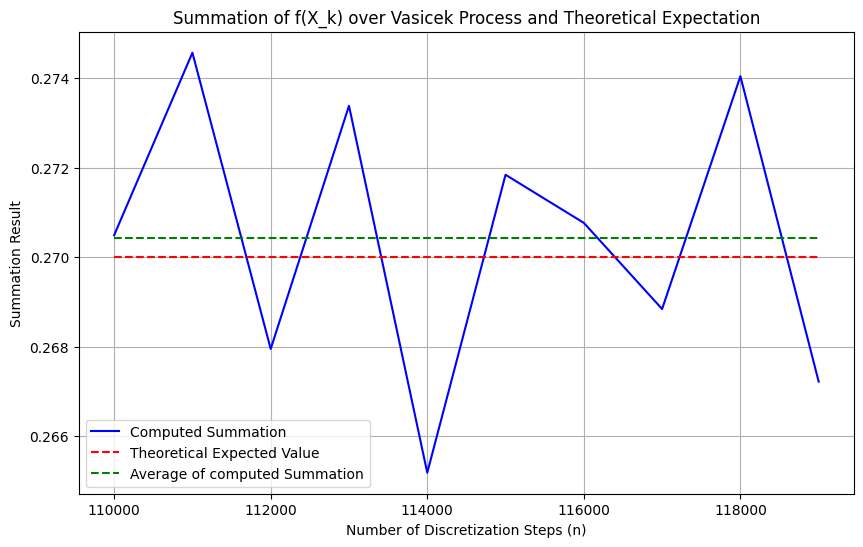

In [124]:

X0 = 0.05  # Initial value
N = 1  # Only 1 trajectory for the summation computation
n_values = range(110000, 120000, 1000)  # Range of n values for testing
n = 2 # Choose a large n for comparison

# Define the function to apply to each X_k
f = lambda x: x**n# Example: x^3

# Compute the summation for each value of n
Y = [calculate_sum(n, f, kappa=kappa_true, theta=theta_true, sigma=sigma_true, X0=X0) for n in n_values]
y0 = sum(Y)/len(Y)
# Compute the true value of the expectation
true_value = expected_value_vasicek(n, theta_true, sigma_true, kappa_true)
Y0 = [true_value for _ in n_values]  # Create a constant list for the theoretical expected value
Y1 = [y0 for _ in n_values]
# Print the theoretical expected value
print("Theoretical Expected Value:", true_value)
print("Average of computed Summation:", y0)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, Y, label="Computed Summation", color="blue")
plt.plot(n_values, Y0, label="Theoretical Expected Value", color="red", linestyle="--")
plt.plot(n_values, Y1, label="Average of computed Summation", color="green", linestyle="--")
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process and Theoretical Expectation")
plt.legend()
plt.grid(True)
plt.show()


In [125]:
def calculate_expression(sigma, kappa, t):
    """
    Calculate the value of the expression: (sigma^2 / (2 * kappa)) * exp(-kappa * t)
    
    Parameters:
    sigma (float): The sigma parameter.
    kappa (float): The kappa parameter.
    t (float): The time variable.
    
    Returns:
    float: The computed value of the expression.
    """
    numerator = sigma ** 2
    denominator = 2 * kappa
    exponential_term = math.exp(-kappa * t)
    result = (numerator / denominator) * exponential_term
    return result
def ergodic_estimator(X, h, theta_hat):
    """
    Compute the ergodic estimator for σ^2 / (2κ) * exp(-κh).
    
    Parameters:
    X (np.array): Simulated Vasicek process.
    h (int): Lag.
    theta_hat (float): Estimator of θ.
    
    Returns:
    float: The computed ergodic estimator.
    """
    n = len(X)
    sum_term = 0
    for k in range(n - h):
        sum_term += X[k] * X[k + h]
    return (1 / n) * sum_term - theta_hat**2


In [126]:
def calculate_expression(sigma, kappa, t):
    """
    Calculate the value of the expression: (sigma^2 / (2 * kappa)) * exp(-kappa * t)
    
    Parameters:
    sigma (float): The sigma parameter.
    kappa (float): The kappa parameter.
    t (float): The time variable.
    
    Returns:
    float: The computed value of the expression.
    """
    numerator = sigma ** 2
    denominator = 2 * kappa
    exponential_term = math.exp(-kappa * t)
    result = (numerator / denominator) * exponential_term
    return result

In [127]:
number_of_moments = 2
number_of_lags = 10
# True values for parameters
kappa_true = 1  # True speed of mean reversion
theta_true = 0.5  # True long-term mean
sigma_true = 0.2  # True volatility
T = 5000
number_of_points  = 100000
# Generate synthetic data
Z_true = np.zeros(number_of_moments+number_of_lags)
for i in range(number_of_moments):
    Z_true[i] = expected_value_vasicek(i + 1, theta_true, sigma_true, kappa_true)
for i in range(number_of_moments,number_of_moments+number_of_lags):
    Z_true[i] = calculate_expression(sigma_true, kappa_true, (i - number_of_moments + 1)*(T/number_of_points))
def matrix_calculator(params):
        
        theta, sigma, kappa = params
        loss = (theta - theta_true)**2 + (sigma - sigma_true)**2 + (kappa - kappa_true)**2
        print(f"Current Parameters: theta = {theta}, sigma = {sigma}, kappa = {kappa}")

        # Initialize Z and Y arrays
        Y = np.zeros(number_of_moments+number_of_lags)
        vasicek_process = Vasicek(kappa, theta, sigma)
        # Time horizon

        # Generate one trajectory
        trajectories = vasicek_process.generate(0.05, T, 1, number_of_points)  # One trajectory, n steps
        trajectory = trajectories[0]  # Take the first trajectory
        theta_h = np.mean(trajectory)
        for i in range(number_of_moments):
            res = 0 
            f = lambda x: x**(i+1)
            res +=(1 / number_of_points) * sum(f(x) for x in trajectory)
            Y[i] = res
        for i in range(number_of_moments,number_of_moments+number_of_lags):
            h = i - number_of_moments + 1
            Y[i] = ergodic_estimator(trajectory, h, theta_h)
        # Compute the difference and return the sum of squares
        diff = Y - Z_true
        print("current loss is ", np.dot(diff, diff))
        return np.dot(diff, diff)

In [128]:

def parameter_estimator():
    # Initial guess for [theta, sigma, kappa]
    initial_guess = [0.5, 0.7, 0.8]
    print("Initial Guess:", initial_guess)
    # theta, sigma, kappa = params
    # Perform minimization with Nelder-Mead
    res = minimize(matrix_calculator, initial_guess, method='Nelder-Mead',
                   options={'xatol': 1e-6, 'maxfev': 10000, 'disp': True})
    
    # Output the results
    print("Optimization Success:", res.success)   # Check if optimization succeeded
    print("Optimization Message:", res.message)   # Check why it may have failed
    print("Final Objective Function Value:", res.fun)  # Final value of the objective function
    print("Optimized Parameters:", res.x)         # Optimized parameters (theta, sigma, kappa)
    
    return res.x

# Example usage
print("True Parameters:", [theta_true, sigma_true, kappa_true])
optimized_params = parameter_estimator()
print("Optimized Parameters:", optimized_params)
print("True Parameters:", [theta_true, sigma_true, kappa_true])
print("True error value :",matrix_calculator((theta_true, sigma_true, kappa_true)))

True Parameters: [0.5, 0.2, 1]
Initial Guess: [0.5, 0.7, 0.8]
Current Parameters: theta = 0.5, sigma = 0.7, kappa = 0.8
current loss is  0.4293167061909106
Current Parameters: theta = 0.525, sigma = 0.7, kappa = 0.8
current loss is  0.41550227809824825
Current Parameters: theta = 0.5, sigma = 0.735, kappa = 0.8
current loss is  0.4815003704041242
Current Parameters: theta = 0.5, sigma = 0.7, kappa = 0.8400000000000001
current loss is  0.39099730670245875
Current Parameters: theta = 0.5166666666666666, sigma = 0.6649999999999997, kappa = 0.8266666666666669
current loss is  0.3176100942041567
Current Parameters: theta = 0.5249999999999999, sigma = 0.6299999999999997, kappa = 0.8400000000000003
current loss is  0.23581813615050978
Current Parameters: theta = 0.5333333333333332, sigma = 0.6533333333333329, kappa = 0.8533333333333335
current loss is  0.30282766173010306
Current Parameters: theta = 0.5138888888888887, sigma = 0.6222222222222218, kappa = 0.8888888888888893
current loss is  0.

<h1>Maximum Likelihood Estimator (MLE)</h1>


In [129]:

n= 500000
T= 50
vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
    # Generate one trajectory of the process
trajectories = vasicek_process.generate(0.05, T, 1, n)  # One trajectory, n steps
trajectory = trajectories[0] 

In [130]:

def negative_log_likelihood(params):
    """
    Compute the log-likelihood for the Vasicek process given parameters.
    
    :param sigma: Volatility parameter (standard deviation)
    :param theta: Long-term mean level
    :param kappa: Speed of mean reversion
    :param n: Number of discretization steps
    :param T: Total time period (default is 1)
    
    :return: Log-likelihood value
    """
    # Create the Vasicek process model with given parameters
 # Take the first trajectory as the observed data
    sigma, theta, kappa = params

    dt = T / n  # Time step size

    # Initialize log-likelihood value
    log_likelihood_value = 0

    # First part of the log-likelihood
    term1 = -n / 2 * np.log(sigma**2 / (2 * kappa * (1 - np.exp(-2 * kappa * dt))))
    log_likelihood_value += term1
    # Third part: Sum of squared residuals
    residual_sum = 0
    for i in range(1, n):
        expected_value = trajectory[i - 1] * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
        residual = trajectory[i] - expected_value
        residual_sum += residual**2
    
    # Fourth part: the sum over residuals
    term3 = -(kappa / (sigma**2 * (1 - np.exp(-2 * kappa * dt)))) * residual_sum
    log_likelihood_value += term3

    return -log_likelihood_value


In [131]:

n= 100000
T= 5000
vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
    # Generate one trajectory of the process
trajectories = vasicek_process.generate(0.05, T, 1, n)  # One trajectory, n steps
trajectory = trajectories[0] 
def estimate_parameters(trajectory = trajectory, T = T):
    n = len(trajectory)
    delta_t = T / n
    Rt = np.array(trajectory)
    
    # Calculate terms
    Rt_shifted = Rt[:-1]  # R_{t_{i-1}}
    Rt_current = Rt[1:]  # R_{t_i}
    
    #  (kappa)
    mean_RtRt_shifted = np.mean(Rt_current * Rt_shifted)
    mean_Rt = np.mean(Rt_current)
    mean_Rt_shifted = np.mean(Rt_shifted)
    mean_Rt_shifted_squared = np.mean(Rt_shifted ** 2)
    
    numerator_alpha = mean_RtRt_shifted - mean_Rt * mean_Rt_shifted
    denominator_alpha = mean_Rt_shifted_squared - mean_Rt_shifted ** 2
    kappa = -1 / delta_t * np.log(numerator_alpha / denominator_alpha)
    
    #  (theta)
    numerator_theta = np.sum(Rt_current) - np.exp(kappa * delta_t) * np.sum(Rt_shifted)
    denominator_theta = n * (1 - np.exp(-kappa * delta_t))
    theta = numerator_theta / denominator_theta
    
    # sigma^2
    term1 = Rt_current - Rt_shifted * np.exp(-kappa * delta_t)
    term2 = theta * (1 - np.exp(-kappa * delta_t))
    sigma_squared = (2 * kappa) / (n * (1 - np.exp(-2 * kappa * delta_t))) * np.sum((term1 - term2) ** 2)
    
    return kappa, theta, np.sqrt(sigma_squared)
kappa, theta, sigma = estimate_parameters()
print('kappa is ', kappa)
print('theta is ', abs(theta))
print('sigma is ', sigma)
print('true kappa is ', kappa_true)
print('true theta is ',abs( theta_true))
print('true sigma is', sigma_true)

kappa is  0.9898746683258742
theta is  0.5270860050625785
sigma is  0.3035766959026095
true kappa is  1
true theta is  0.5
true sigma is 0.2
